In [1]:
# Notebook for the design of a simple FIR filter for feasiblity testing

from scipy import signal
from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

def simple_fir(b, data):
    y=[]
    for j in range(0, len(data) - len(b)):
        y_i=0
        for i, b_i in enumerate(b):
            y_i += b_i*data[j+i]
        y.append(y_i)
    return y

In [2]:
# Chirp data generate
n=3000 # number of samples to use for the chirp
fs=20000 # The sampling rate for the chrip
f0=100# the start frequency in Hz for the chirp
f1=1000 # the stop frequency of the chirp
t1=n/fs # the total length of the chirp in s

t_chrip = np.linspace(0, t1, n)
# generate a chrip and scale to int16 (1 bit for sign)
y_chrip = np.round(signal.chirp(t_chrip, f0=f0, f1=f1, t1=t1, method='linear')*(2**15-1)).astype(int)
cutsamps = 45
y_chrip = y_chrip[cutsamps:]
t_chrip = t_chrip[cutsamps:]

# Generate an array were the data is present in an interleaved format with the inverted signal 
y_chrip_interleaved = np.empty((2*y_chrip.size), dtype=y_chrip.dtype)
y_chrip_interleaved[0::2] = y_chrip
y_chrip_interleaved[1::2] = -1*y_chrip[::-1]

file_str= f"#define CHIRP_DATA_SAMPLE_RATE {int(fs)}\n"\
          "#define CHIRP_DATA_LEN"f" {y_chrip.size}" "\n"\
          "#define CHIRP_DATA_INTERLEAVED_LEN"f" {y_chrip_interleaved.size}" "\n"\
          "#define CHIRP_DATA {" + ",".join(y_chrip.astype(str)) +"}\n"\
          "#define CHIRP_DATA_INTERLEAVED_INVERTED {" + ",".join(y_chrip_interleaved.astype(str)) +"}" "\n"

with open("pcm_chirp/include/chirp_data.h", "w") as f:
    f.write(file_str)

interactive(children=(IntSlider(value=40, description='numtaps', step=2), IntSlider(value=100, description='f_…

<function __main__.update(numtaps=40, f_cut=100)>

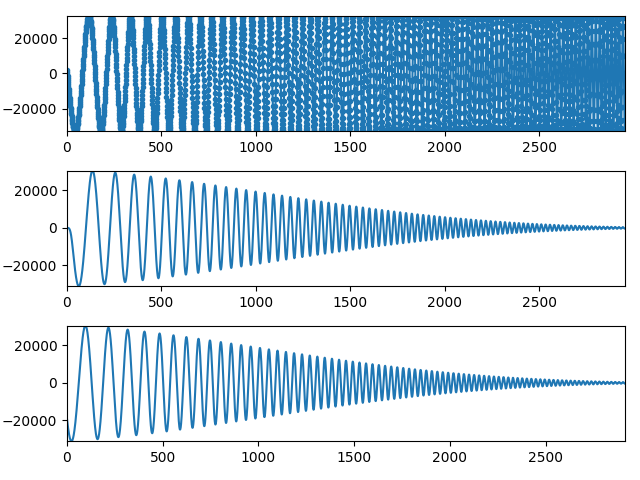

In [3]:
%matplotlib widget

b=signal.firwin(20, 100, fs=fs)
y_lfiltered = signal.lfilter(b, [1.0], y_chrip)
yf=fft(y_lfiltered)
xf = fftfreq(n, t1/n)[:n//2]

cols = 1
rows = 3

fig = plt.figure(1)
ax1 = fig.add_subplot(rows, cols, 1)
line1, = ax1.plot([0], ".-", label = "chrip")
ax2 = fig.add_subplot(rows, cols, 2)
line2, = ax2.plot([0], label="chrip filtered signal.lfilter")
ax3 = fig.add_subplot(rows, cols, 3)
line3, = ax3.plot([0], label="own fir implementation")

def update(numtaps = 40, f_cut=100):
    # Calculate the filter coefficients for given paramters
    b=signal.firwin(numtaps, f_cut, fs=fs)
    print(f"Filter coeffs for {numtaps} tabs and {f_cut}Hz cutoff are:\n", b)
    
    bits=16
    if min(b)<0:
        bits=bits-1
    
    print(f"Filter coeffs converted to Q1.{bits}bit int are :\n", 
          ", ".join(
                np.array(np.array(np.round(b*(2**(bits)-1)), dtype=np.int32), dtype=str)
            )
        )

    # plot the chirp
    line1.set_data(range(len(y_chrip)), y_chrip)
    ax1.set_xlim(0, len(y_chrip))
    ax1.set_ylim(min(y_chrip), max(y_chrip))

    # Apply the coefficents with scipy function
    y_lfiltered = signal.lfilter(b, [1.0], y_chrip)
    line2.set_data(range(len(y_lfiltered)), y_lfiltered)
    ax2.set_xlim(0, len(y_lfiltered))
    ax2.set_ylim(min(y_lfiltered), max(y_lfiltered))

    # yf=2.0/n*np.abs(fft(y_chrip[:n//2]))
    # xf = fftfreq(n, t1/n)[:n//2]
    data = simple_fir(b, y_chrip)
    line3.set_data(range(len(data)), data)
    ax3.set_xlim(0, len(data))
    ax3.set_ylim(min(data), max(data))

    fig.canvas.draw_idle()
    # save coefficients to file
    with open("pcm_data_processing/include/coefficients.h", "w") as f:
        f.write(
            "#define NUMTAPS " + str(numtaps) + "\n" +
            "#define COEFFICIENTS {" + ",".join(np.array(np.array(np.round(b*(2**(bits)-1)), dtype=np.int32), dtype=str)) +"}" "\n"
        )

plt.tight_layout()
interact(update, numtaps=(0, 100,2), f_cut=(100,5000))

